# NER using RNN, spaCy and Transformers

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast

**Load dataset**

In [3]:
def load_data(data_path):
    df = pd.read_csv(data_path)
    # Remove null values if any
    df.dropna(inplace=True)
    print("Number of records: ",len(df))
    return df

In [87]:
df = load_data(r'/kaggle/input/named-entity-recognition-ner-corpus/ner.csv')
df.head()

Number of records:  47959


,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


**Pre-processing the dataset**

In [91]:
def preprocess_data(df):
    for i in range(len(df)):
        pos = ast.literal_eval(df['POS'][i])
        tags = ast.literal_eval(df['Tag'][i])
        df['POS'][i] = [str(word) for word in pos]
        df['Tag'][i] = [str(word.upper()) for word in tags]
    return df

In [92]:
df = preprocess_data(df)
df.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"[NNS, IN, NNS, VBN, IN, DT, NN, VBD, DT, NNS, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"[PRP, VBD, IN, DT, NNS, IN, NN, TO, DT, NN, IN...","[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","[NNS, VBD, DT, NN, IN, NNS, IN, CD, IN, NNS, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 5,The protest comes on the eve of the annual con...,"[DT, NN, VBZ, IN, DT, NN, IN, DT, JJ, NN, IN, ...","[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,..."


In [93]:
df['Tag'][0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GEO',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GEO',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-GPE',
 'O',
 'O',
 'O',
 'O',
 'O']

**Split the dataset into train and test**

In [109]:
df_final = df[['Sentence','Tag']]

df_train,df_test = train_test_split(df_final,test_size=0.2,random_state=42)
len(df_train),len(df_test)

(38367, 9592)

# Method 1: RNN

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,Bidirectional,LSTM,Embedding
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping

**Convert sentences to sequences**

In [9]:
train_targets = list(df_train.Tag.values)
test_targets = list(df_test.Tag.values)

tokenizer = Tokenizer(lower=False,oov_token="UNK")
tokenizer.fit_on_texts(df_train['Sentence'])

train_inputs = tokenizer.texts_to_sequences(df_train['Sentence'])
test_inputs = tokenizer.texts_to_sequences(df_test['Sentence'])

**Word to integer mapping**

In [10]:
word2idx = tokenizer.word_index
V = len(word2idx) # Vocab size
print("Found %s unique tokens "%V)

Found 28761 unique tokens 


**Unique NER tags**

In [11]:
train_tags = set([val for sublist in train_targets for val in sublist])
test_tags = set([val for sublist in test_targets for val in sublist])

print("Unique NER tags in train set: ",train_tags)
print("Unique NER tags in test set: ",test_tags)

Unique NER tags in train set:  {'B-GEO', 'B-PER', 'I-ORG', 'B-NAT', 'I-ART', 'O', 'I-NAT', 'I-GEO', 'I-TIM', 'I-EVE', 'B-GPE', 'B-TIM', 'B-ORG', 'B-EVE', 'I-PER', 'B-ART', 'I-GPE'}
Unique NER tags in test set:  {'B-GEO', 'B-PER', 'I-ORG', 'B-NAT', 'I-ART', 'O', 'I-NAT', 'I-GEO', 'I-TIM', 'I-EVE', 'B-GPE', 'B-TIM', 'B-ORG', 'B-EVE', 'I-PER', 'B-ART', 'I-GPE'}


**Convert targets to sequences**

In [12]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_tgt_int = tag_tokenizer.texts_to_sequences(train_targets)
test_tgt_int = tag_tokenizer.texts_to_sequences(test_targets)

**Padding sequences**

In [14]:
# Max length
max_length_train = max(len(sent) for sent in train_inputs)
max_length_test = max(len(sent) for sent in test_inputs)
max_length = max(max_length_train,max_length_test)

# Pad input sequences
train_inputs_final = pad_sequences(train_inputs,maxlen=max_length,padding="post")
print("Shape of train inputs: ",train_inputs_final.shape)

test_inputs_final = pad_sequences(test_inputs,maxlen=max_length,padding="post")
print("Shape of test inputs: ",test_inputs_final.shape)

train_targets_final = pad_sequences(train_tgt_int,maxlen=max_length,padding="post")
print("Shape of train targets: ",train_targets_final.shape)

test_targets_final = pad_sequences(test_tgt_int,maxlen=max_length,padding="post")
print("Shape of test targets: ",test_targets_final.shape)

Shape of train inputs:  (38367, 89)
Shape of test inputs:  (9592, 89)
Shape of train targets:  (38367, 89)
Shape of test targets:  (9592, 89)


In [15]:
# Number of classes

K = len(tag_tokenizer.word_index)  +1
K

18

**Build Model**

In [16]:
vector_size = 16

i = Input(shape=(max_length,))
x = Embedding(input_dim= V+1,output_dim=vector_size,mask_zero=True)(i)
x = Bidirectional(LSTM(32,return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i,x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 89)]              0         
                                                                 
 embedding (Embedding)       (None, 89, 16)            460192    
                                                                 
 bidirectional (Bidirectiona  (None, 89, 64)           12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 89, 18)            1170      
                                                                 
Total params: 473,906
Trainable params: 473,906
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile and fit

model.compile(optimizer="adam",loss=SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
model.fit(train_inputs_final,
          train_targets_final,
          epochs=6,
          validation_data=(test_inputs_final,test_targets_final))

Epoch 1/6
1199/1199 [==============================] - 50s 34ms/step - loss: 0.2470 - accuracy: 0.9178 - val_loss: 0.3121 - val_accuracy: 0.9029
Epoch 2/6
1199/1199 [==============================] - 23s 20ms/step - loss: 0.2248 - accuracy: 0.9246 - val_loss: 0.3131 - val_accuracy: 0.9041
Epoch 3/6
1199/1199 [==============================] - 22s 18ms/step - loss: 0.2063 - accuracy: 0.9306 - val_loss: 0.3179 - val_accuracy: 0.9049
Epoch 4/6
1199/1199 [==============================] - 21s 17ms/step - loss: 0.1906 - accuracy: 0.9358 - val_loss: 0.3199 - val_accuracy: 0.9038
Epoch 5/6
1199/1199 [==============================] - 21s 18ms/step - loss: 0.1776 - accuracy: 0.9398 - val_loss: 0.3288 - val_accuracy: 0.9048
Epoch 6/6
1199/1199 [==============================] - 20s 17ms/step - loss: 0.1662 - accuracy: 0.9437 - val_loss: 0.3332 - val_accuracy: 0.9041


**Predictions**

In [39]:
sentence = "Polish Prime Minister Jaroslaw Kaczynski has voiced support for the deployment of 10 U.S. missile interceptors in Poland and guidance technology in the Czech Republic ."
predictions = model.predict(pad_sequences(tokenizer.texts_to_sequences([sentence]),
                                          maxlen=max_length,
                                         padding="post"))
predictions

1/1 [==============================] - 0s 21ms/step


array([[[-9.842232  ,  4.243041  , -2.721947  , ...,  1.3335929 ,
         -2.4619546 , -3.632022  ],
        [-6.8601546 ,  2.927383  , -3.5464454 , ..., -1.3569822 ,
         -2.037763  , -3.1719928 ],
        [-6.151436  ,  5.9519176 , -4.704682  , ...,  0.5193087 ,
         -0.55176234, -0.67221606],
        ...,
        [-0.04260799,  0.32441294,  0.09599943, ..., -0.25296417,
         -0.18850267, -0.1600227 ],
        [-0.04260799,  0.32441294,  0.09599943, ..., -0.25296417,
         -0.18850267, -0.1600227 ],
        [-0.04260799,  0.32441294,  0.09599943, ..., -0.25296417,
         -0.18850267, -0.1600227 ]]], dtype=float32)

In [40]:
pred_ner = np.argmax(predictions,axis=-1)
pred_ner

array([[8, 6, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6]])

In [47]:
NER_tags = [tag_tokenizer.index_word[num] for num in list(pred_ner.flatten())]
NER_tags

['b-gpe',
 'b-per',
 'o',
 'o',
 'i-per',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'b-geo',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per',
 'b-per']

# Method 2: spaCy

In [12]:
import spacy
from spacy.tokens import DocBin
from spacy.util import filter_spans
from tqdm import tqdm

**Convert dataset into format for spacy conversion**

In [105]:
df_final.reset_index(drop=True,inplace=True)
df_final.head()

,Sentence,Tag
0,Thousands of demonstrators have marched throug...,"[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO..."
1,Families of soldiers killed in the conflict jo...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,They marched from the Houses of Parliament to ...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO..."
3,"Police put the number of marchers at 10,000 wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,The protest comes on the eve of the annual con...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,..."


In [107]:
len(df_final)

47959

In [77]:
nlp = spacy.load("en_core_web_lg",disable=["tagger","parser","ner","lemmatizer"])

In [78]:
# Modifying the spacy tokenizer to not split on hyphens

from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER
from spacy.lang.char_classes import CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex

# Modify tokenizer infix patterns
infixes = (
    LIST_ELLIPSES
    + LIST_ICONS
    + [
        r"(?<=[0-9])[+\\-\\*^](?=[0-9-])",
        r"(?<=[{al}{q}])\\.(?=[{au}{q}])".format(
            al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
        ),
        r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
        # ✅ Commented out regex that splits on hyphens between letters:
        # r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
        r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
    ]
)

infix_re = compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer

In [150]:
final_data = []
for i in range(len(df_final)):
    temp_dict = {}
    temp_dict['text'] = df_final['Sentence'][i]
    temp_dict['entities'] = []
    doc = nlp(df_final['Sentence'][i])
    tag = df_final['Tag'][i]
    for token in doc:
        m = 0
        start = token.idx
        end = start + len(token.text)
        label = tag[m]
        temp_dict['entities'].append((start,end,label))
        m += 1
    final_data.append(temp_dict)

In [153]:
final_data[0]

{'text': 'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'entities': [(0, 9, 'O'),
  (10, 12, 'O'),
  (13, 26, 'O'),
  (27, 31, 'O'),
  (32, 39, 'O'),
  (40, 47, 'O'),
  (48, 54, 'O'),
  (55, 57, 'O'),
  (58, 65, 'O'),
  (66, 69, 'O'),
  (70, 73, 'O'),
  (74, 76, 'O'),
  (77, 81, 'O'),
  (82, 85, 'O'),
  (86, 92, 'O'),
  (93, 96, 'O'),
  (97, 107, 'O'),
  (108, 110, 'O'),
  (111, 118, 'O'),
  (119, 125, 'O'),
  (126, 130, 'O'),
  (131, 135, 'O'),
  (136, 143, 'O'),
  (144, 145, 'O')]}

In [154]:
# Split data into train and test
print("Number of records: ",len(final_data))
train = final_data[:int(0.85*len(final_data))]
test = final_data[int(0.85*len(final_data)):]

print("\nTrain data length: ",len(train))
print("Test data length: ",len(test))

Number of records:  47959

Train data length:  40765
Test data length:  7194


**Convert data to spacy binary files**

In [155]:
nlp = spacy.blank("en")
def convert_data(data,output_path):
    # create a docbin object
    db = DocBin()
    for example in tqdm(data):
        text = example['text']
        labels = example['entities']
        # create a doc object from text
        doc = nlp.make_doc(text)
        ents = []
        for start,end,label in labels:
            span = doc.char_span(start,end,label=label,alignment_mode="contract")
            if span is not None:
                ents.append(span)
        filtered_ents = filter_spans(ents)
        doc.ents = filtered_ents
        db.add(doc)
    db.to_disk(output_path)

In [156]:
convert_data(train,'/kaggle/working/train.spacy')
convert_data(test,'/kaggle/working/dev.spacy')

100%|██████████| 7194/7194 [00:02<00:00, 2721.25it/s]


**Training using spaCy config files in Anaconda Terminal**

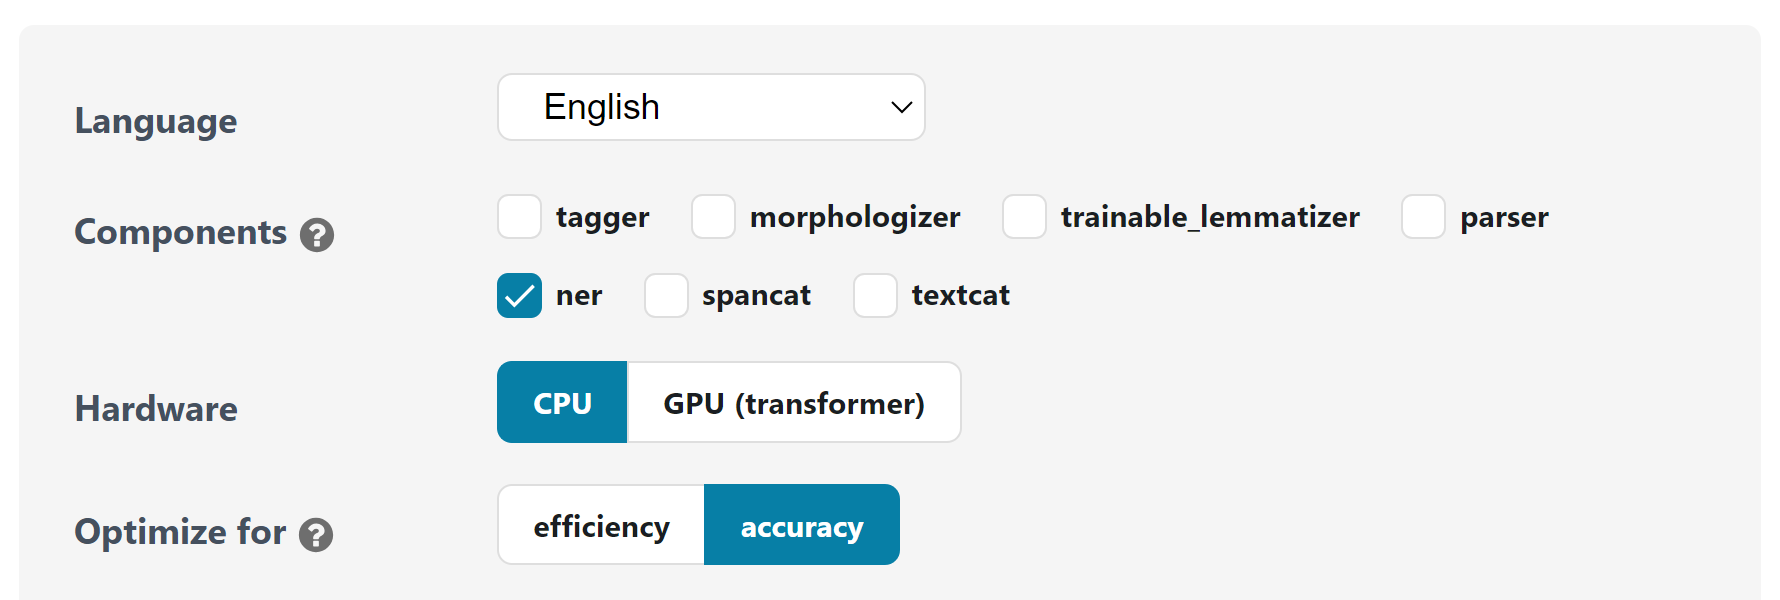

**python -m spacy init fill-config base_config.cfg config.cfg**

**python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./dev.spacy**

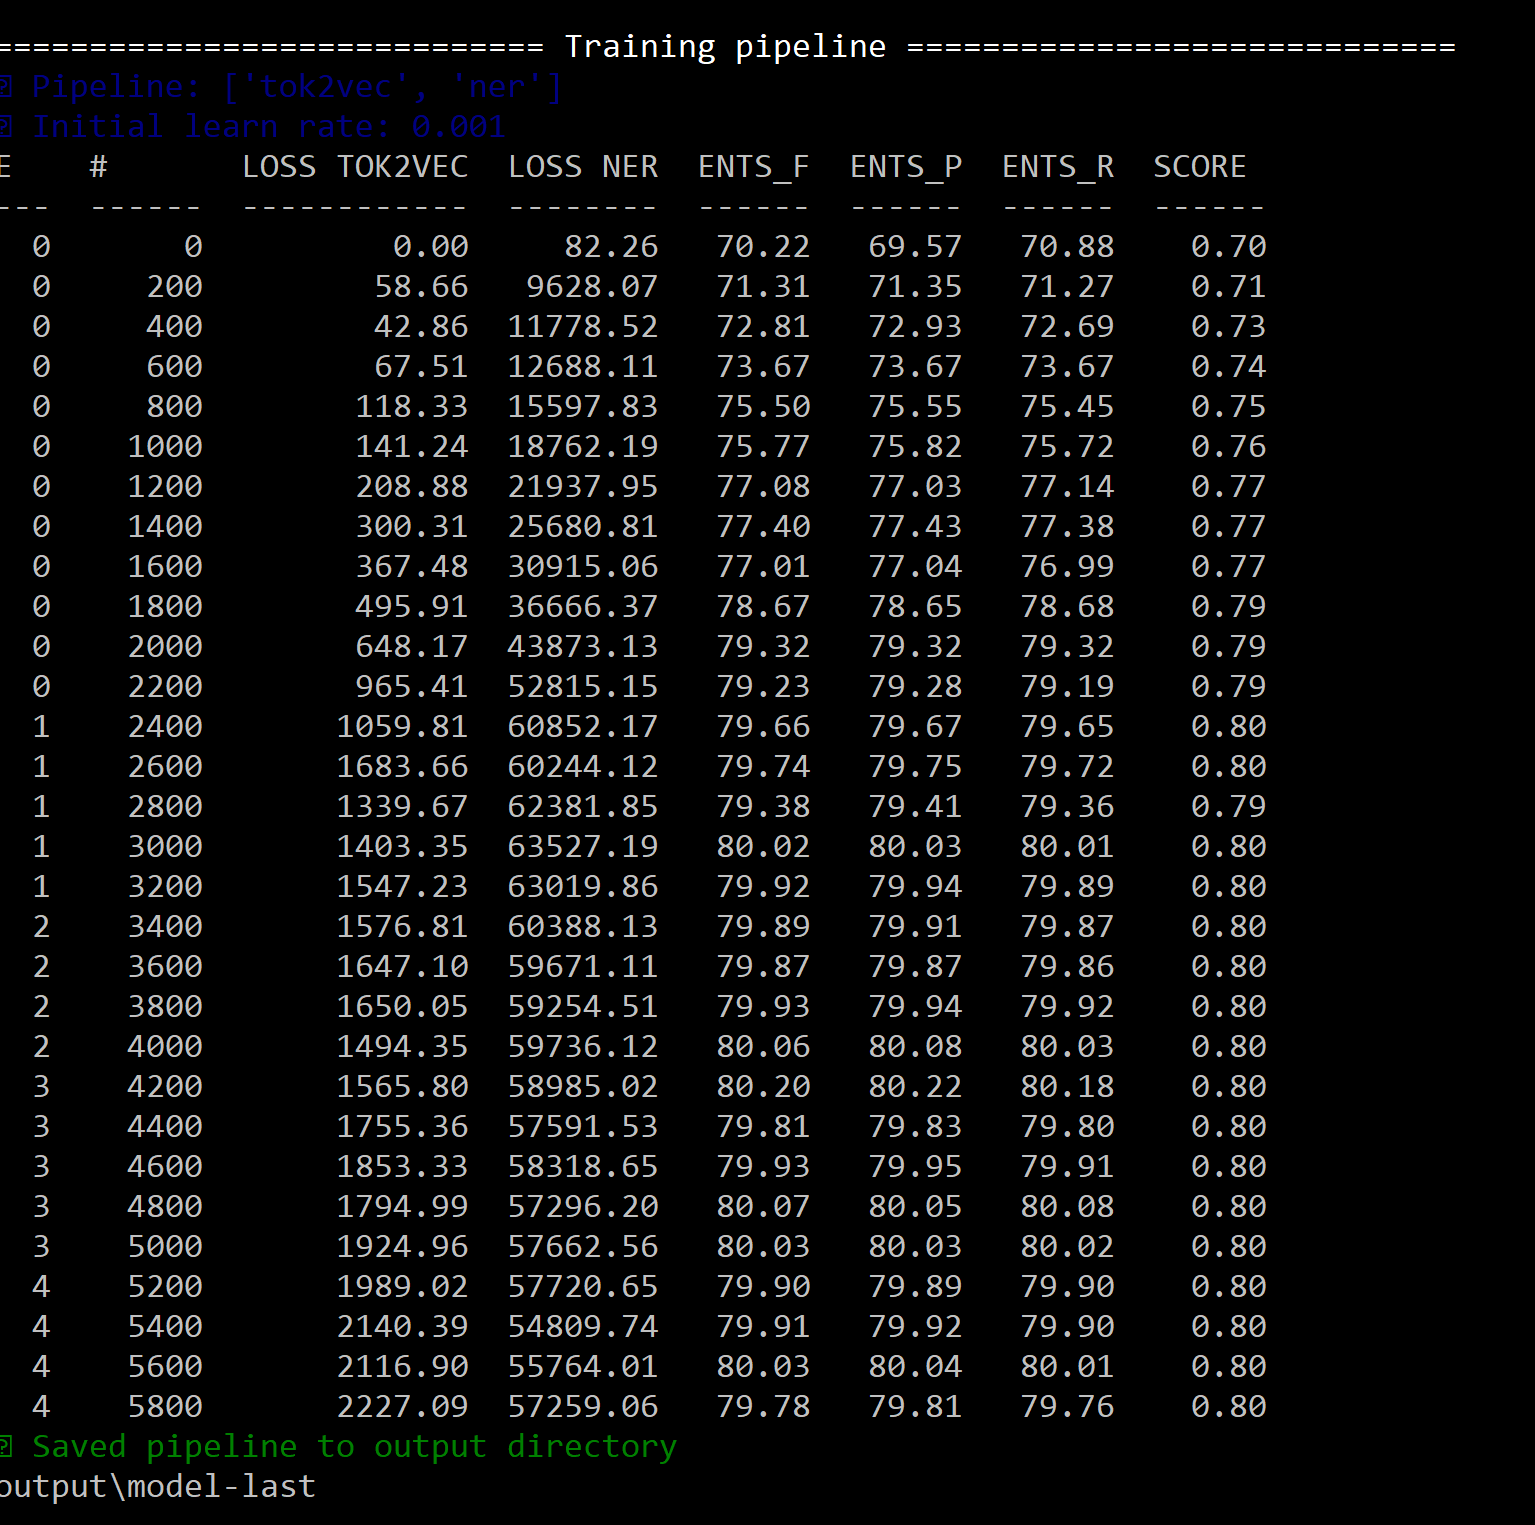

**The accuracy from spaCy's NER training is really low at 0.8. This will show up in predictions also.**

**Predictions**

nlp_ner = spacy.load("./output/model-best")

example = "Russia has taken 11 percent of Ukraine's territory since the start of the war, an area equivalent to Massachusetts, New Hampshire and Connecticut combined, according to the Belfer Center at the Harvard Kennedy School."

doc = nlp_ner(example)

spacy.displacy.render(doc, style="ent", jupyter=True)

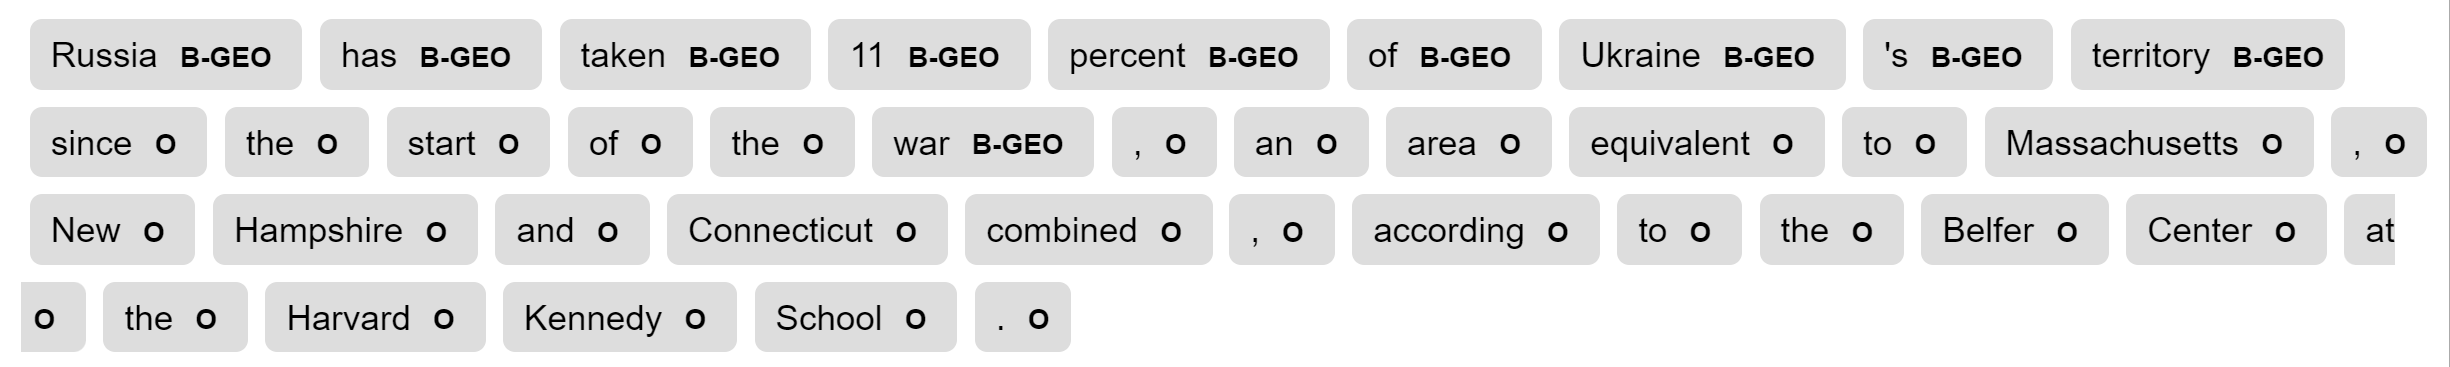

# Method 3: Transformers (Fine Tuning)

In [9]:
!pip install evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=fff2b9b1269401e8166ff39cc873d144adb9732bfb67375ae8891baee8a128d3
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


**Converting data into datasets format**

In [110]:
df_final.head()

,Sentence,Tag
0,Thousands of demonstrators have marched throug...,"[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO..."
1,Families of soldiers killed in the conflict jo...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,They marched from the Houses of Parliament to ...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO..."
3,"Police put the number of marchers at 10,000 wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,The protest comes on the eve of the annual con...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,..."


In [111]:
# Unique labels
labels = [set([val for sublist in df_final['Tag'].values for val in sublist])]

# Label2index
label2index = {"O":0,"B-PER":1,"I-PER":2,"B-GEO":3,"I-GEO":4,"B-ART":5,"I-ART":6,
              "B-GPE":7,"I-GPE":8,"B-EVE":9,"I-EVE":10,"B-NAT":11,"I-NAT":12,"B-ORG":13,
              "I-ORG":14,"B-TIM":15,"I-TIM":16}

index2label = {v:k for k,v in label2index.items()}

In [112]:
# Create a column with the tokens for each sentence and numeric labels

def create_tokens(text):
    data = [word for word in text.split()]
    return data

def create_num_labels(label):
    num_label = [label2index[text] for text in label]
    return num_label

df_trf = df_final.copy()
df_trf.loc[:,'Tokens'] = df_trf['Sentence'].apply(lambda x: create_tokens(x))
df_trf.loc[:,'NER_Tags'] = df_trf['Tag'].apply(lambda label:create_num_labels(label))

# Remove rows with unequal # tokens and # tags
index_labels = []
for i in range(len(df_trf)):
    if len(df_trf['Tokens'][i]) != len(df_trf['NER_Tags'][i]):
        print(f"Tokens and tags at index {i} don't match")
        index_labels.append(i)
        
# Drop rows at index positions in index_labels
for idx in index_labels:
    df_trf.drop(index=idx,inplace=True)

# Reset index
df_trf.reset_index(drop=True,inplace=True)

# Select relevant columns only
df_trf = df_trf[['Tokens','NER_Tags']]
df_trf.head()

Tokens and tags at index 76 don't match
Tokens and tags at index 10051 don't match
Tokens and tags at index 19817 don't match
Tokens and tags at index 47591 don't match


,Tokens,NER_Tags
0,"[Thousands, of, demonstrators, have, marched, ...","[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, ..."
1,"[Families, of, soldiers, killed, in, the, conf...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[They, marched, from, the, Houses, of, Parliam...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0]"
3,"[Police, put, the, number, of, marchers, at, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[The, protest, comes, on, the, eve, of, the, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 13,..."


In [113]:
len(df_trf)

47955

In [114]:
# Converting the dataframe to a dictionary for better conversion
df_dict = df_trf.to_dict('list')

In [115]:
from datasets import Dataset, load_dataset
raw_dataset = Dataset.from_dict(df_dict)
raw_dataset

Dataset({
    features: ['Tokens', 'NER_Tags'],
    num_rows: 47955
})

In [116]:
raw_dataset[0]

{'Tokens': ['Thousands',
  'of',
  'demonstrators',
  'have',
  'marched',
  'through',
  'London',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'Iraq',
  'and',
  'demand',
  'the',
  'withdrawal',
  'of',
  'British',
  'troops',
  'from',
  'that',
  'country',
  '.'],
 'NER_Tags': [0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  0,
  0]}

**Split into train and test**

In [119]:
split = raw_dataset.train_test_split(test_size=0.15,shuffle=True,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['Tokens', 'NER_Tags'],
        num_rows: 40761
    })
    test: Dataset({
        features: ['Tokens', 'NER_Tags'],
        num_rows: 7194
    })
})

**Tokenizing**

In [121]:
from transformers import AutoTokenizer
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [122]:
example = split["train"][0]
tokenized_input = tokenizer(example["Tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'The',
 'NL',
 '##D',
 'was',
 'founded',
 'in',
 '1988',
 ',',
 'after',
 'the',
 'military',
 'crushed',
 'a',
 'pro',
 '-',
 'democracy',
 'uprising',
 'in',
 'Burma',
 '.',
 '[SEP]']

Adding some special tokens [CLS] and [SEP] and the subword tokenization creates a mismatch between the input and labels. A single word corresponding to a single label may now be split into two subwords. We will need to realign the tokens and labels by:

- Mapping all tokens to their corresponding word with the word_ids method.
- Assigning the label -100 to the special tokens [CLS] and [SEP] so they’re ignored by the PyTorch loss function (see CrossEntropyLoss).
- Only labeling the first token of a given word. Assign -100 to other subtokens from the same word.

In [61]:
label_names = [key for key in label2index.keys()]
label_names

['O',
 'B-PER',
 'I-PER',
 'B-GEO',
 'I-GEO',
 'B-ART',
 'I-ART',
 'B-GPE',
 'I-GPE',
 'B-EVE',
 'I-EVE',
 'B-NAT',
 'I-NAT',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'I-TIM']

In [123]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["Tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"NER_Tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [124]:
# Apply the preprocessing function over dataset

tokenized_dataset = split.map(tokenize_and_align_labels,batched=True)
tokenized_dataset

  0%|          | 0/41 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['Tokens', 'NER_Tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 40761
    })
    test: Dataset({
        features: ['Tokens', 'NER_Tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7194
    })
})

**Dynamic Padding**

In [126]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

**Evaluate**

In [127]:
import evaluate
seqeval = evaluate.load("seqeval")

In [128]:
import numpy as np

labels = [label_names[i] for i in example[f"NER_Tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

**Define Model**

In [129]:
len(label_names)

17

In [130]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=17, id2label=index2label, label2id=label2index
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream

**Training**

In [131]:
training_args = TrainingArguments(
    output_dir="ner_model",
    learning_rate=2e-5,
    per_device_train_batch_size=9,
    per_device_eval_batch_size=6,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.159200,0.137780,0.757336,0.762236,0.759778,0.958919
2,0.119900,0.117494,0.773299,0.802252,0.787510,0.964454
3,0.091600,0.112051,0.791623,0.808363,0.799905,0.966687


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=13587, training_loss=0.15596272847664192, metrics={'train_runtime': 705.9052, 'train_samples_per_second': 173.229, 'train_steps_per_second': 19.248, 'total_flos': 1323168585497478.0, 'train_loss': 0.15596272847664192, 'epoch': 3.0})

The accuracy of 0.96 as expected is pretty high from a Transformer approach.

**Predictions**

In [133]:
from transformers import pipeline

ner = pipeline("token-classification",
               model = '/kaggle/working/ner_model/checkpoint-13587',
               device = 0)

In [134]:
text = "On 24 February 2022, Russia invaded Ukraine in an escalation of the Russo-Ukrainian War which began in 2014."
ner(text)

[{'entity': 'B-TIM',
  'score': 0.9104056,
  'index': 2,
  'word': '24',
  'start': 3,
  'end': 5},
 {'entity': 'B-TIM',
  'score': 0.6154653,
  'index': 3,
  'word': 'February',
  'start': 6,
  'end': 14},
 {'entity': 'I-TIM',
  'score': 0.98978406,
  'index': 4,
  'word': '202',
  'start': 15,
  'end': 18},
 {'entity': 'I-TIM',
  'score': 0.98351306,
  'index': 5,
  'word': '##2',
  'start': 18,
  'end': 19},
 {'entity': 'B-GEO',
  'score': 0.9544608,
  'index': 7,
  'word': 'Russia',
  'start': 21,
  'end': 27},
 {'entity': 'B-GEO',
  'score': 0.7784728,
  'index': 9,
  'word': 'Ukraine',
  'start': 36,
  'end': 43},
 {'entity': 'B-TIM',
  'score': 0.9894991,
  'index': 24,
  'word': '2014',
  'start': 103,
  'end': 107}]

In [137]:
text = "Google was founded on September 4, 1998, by American computer scientists Larry Page and Sergey Brin while they were PhD students at Stanford University in California."
ner(text)

[{'entity': 'B-ORG',
  'score': 0.50060636,
  'index': 1,
  'word': 'Google',
  'start': 0,
  'end': 6},
 {'entity': 'B-TIM',
  'score': 0.99779236,
  'index': 5,
  'word': 'September',
  'start': 22,
  'end': 31},
 {'entity': 'I-TIM',
  'score': 0.9954105,
  'index': 6,
  'word': '4',
  'start': 32,
  'end': 33},
 {'entity': 'I-TIM',
  'score': 0.9891689,
  'index': 7,
  'word': ',',
  'start': 33,
  'end': 34},
 {'entity': 'I-TIM',
  'score': 0.98286843,
  'index': 8,
  'word': '1998',
  'start': 35,
  'end': 39},
 {'entity': 'B-GPE',
  'score': 0.9657246,
  'index': 11,
  'word': 'American',
  'start': 44,
  'end': 52},
 {'entity': 'B-PER',
  'score': 0.73230743,
  'index': 14,
  'word': 'Larry',
  'start': 73,
  'end': 78},
 {'entity': 'I-PER',
  'score': 0.50637895,
  'index': 15,
  'word': 'Page',
  'start': 79,
  'end': 83},
 {'entity': 'B-PER',
  'score': 0.8166716,
  'index': 17,
  'word': 'Sergey',
  'start': 88,
  'end': 94},
 {'entity': 'I-PER',
  'score': 0.853563,
  'inde